<a href="https://colab.research.google.com/github/lanej5/mlb/blob/main/elo/offline_2022_06_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# exploring features and simple models



## notebook setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# default fig settings
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (16, 8)})

pd.options.display.max_columns = None

## load data

In [ ]:
gl = pd.read_parquet('/content/drive/My Drive/mlb/features/features.parquet')
team_ids = pd.read_csv('/content/drive/My Drive/mlb/features/team_ids.csv')

In [ ]:
gl.head()

,game_id,date_x,visitor_id,home_id,visitor_L,home_L,date_index,RD,W,interleague,date_y,home_season,home_RD_10,home_RD_20,home_RD_30,home_RD_50,home_RD_100,home_win_pct_10,home_win_pct_20,home_win_pct_30,home_win_pct_50,home_win_pct_100,home_rest_1,home_rest_2,home_rest_3,home_rest_4,home_rest_5,home_rest_6,home_rest_7,home_rest_8,home_rest_9,home_rest_10,home_rest_11,home_rest_12,home_rest_13,home_rest_14,home_off_avg_5,home_off_obp_5,home_off_slg_5,home_def_avg_5,home_def_whip_5,home_def_era_5,home_off_avg_10,home_off_obp_10,home_off_slg_10,home_def_avg_10,home_def_whip_10,home_def_era_10,home_off_avg_20,home_off_obp_20,home_off_slg_20,home_def_avg_20,home_def_whip_20,home_def_era_20,home_off_avg_30,home_off_obp_30,home_off_slg_30,home_def_avg_30,home_def_whip_30,home_def_era_30,home_off_avg_50,home_off_obp_50,home_off_slg_50,home_def_avg_50,home_def_whip_50,home_def_era_50,home_off_avg_100,home_off_obp_100,home_off_slg_100,home_def_avg_100,home_def_whip_100,home_def_era_100,visitor_date,visitor_season,visitor_RD_10,visitor_RD_20,visitor_RD_30,visitor_RD_50,visitor_RD_100,visitor_win_pct_10,visitor_win_pct_20,visitor_win_pct_30,visitor_win_pct_50,visitor_win_pct_100,visitor_rest_1,visitor_rest_2,visitor_rest_3,visitor_rest_4,visitor_rest_5,visitor_rest_6,visitor_rest_7,visitor_rest_8,visitor_rest_9,visitor_rest_10,visitor_rest_11,visitor_rest_12,visitor_rest_13,visitor_rest_14,visitor_off_avg_5,visitor_off_obp_5,visitor_off_slg_5,visitor_def_avg_5,visitor_def_whip_5,visitor_def_era_5,visitor_off_avg_10,visitor_off_obp_10,visitor_off_slg_10,visitor_def_avg_10,visitor_def_whip_10,visitor_def_era_10,visitor_off_avg_20,visitor_off_obp_20,visitor_off_slg_20,visitor_def_avg_20,visitor_def_whip_20,visitor_def_era_20,visitor_off_avg_30,visitor_off_obp_30,visitor_off_slg_30,visitor_def_avg_30,visitor_def_whip_30,visitor_def_era_30,visitor_off_avg_50,visitor_off_obp_50,visitor_off_slg_50,visitor_def_avg_50,visitor_def_whip_50,visitor_def_era_50,visitor_off_avg_100,visitor_off_obp_100,visitor_off_slg_100,visitor_def_avg_100,visitor_def_whip_100,visitor_def_era_100
0,0,1990-04-09,5,2,AL,AL,1.0,3,1,0,1990-04-09,1990,-2.3,0.20,0.000000,-0.04,-0.36,0.60,0.525,0.550000,0.52,0.555,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.322034,0.396040,0.446328,0.257310,1.140351,3.157895,0.253049,0.338667,0.344512,0.284091,1.159091,3.988636,0.272727,0.360208,0.385991,0.243004,1.011782,2.902798,0.265672,0.346526,0.378109,0.249008,1.056548,3.026786,0.268524,0.346982,0.384707,0.258886,1.059242,3.103081,0.268532,0.342600,0.387615,0.265841,1.071618,3.055703,1990-04-09,1990,0.0,-0.90,-1.100000,-0.40,-0.14,0.40,0.450,0.450000,0.48,0.490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.263158,0.345178,0.350877,0.301775,1.313609,3.514793,0.281899,0.358442,0.385757,0.292035,1.247788,3.185841,0.272069,0.344031,0.397974,0.297376,1.298834,3.896501,0.270192,0.330427,0.425962,0.283317,1.243830,4.051333,0.265889,0.337312,0.418659,0.271598,1.180473,3.642604,0.258667,0.336914,0.410667,0.256410,1.136852,3.485689
1,1,1990-04-09,11,0,AL,AL,1.0,-3,0,0,1990-04-09,1990,-0.7,-0.45,-0.933333,-0.42,-0.50,0.45,0.425,0.516667,0.48,0.505,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.315320,0.385108,0.265951,1.091937,3.006961,1990-04-09,1990,-2.1,-1.05,-0.500000,-0.40,-0.08,0.40,0.500,0.466667,0.52,0.500,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.209877,0.250000,0.339506,0.308989,1.365169,4.095506,0.224615,0.265896,0.356923,0.274052,1.250729,3.463557,0.241481,0.296599,0.371852,0.250000,1.116071,3.174107,0.256158,0.317204,0.386207,0.246792,1.122409,3.091807,0.266162,0.326282,0.400699,0.249265,1.109347,3.190476,0.263561,0.330246,0.381486,0.238667,1.051936,2.966677


## logistic regression

In [ ]:
y = gl[['W', 'RD']]
X_context = gl[['interleague']]
X_h = gl[[c for c in gl.columns if c.startswith('home')]].copy().drop(columns=['home_L', 'home_id'])
X_h = X_h.rename(columns={c: c[4:] for c in X_h.columns})
X_v = gl[[c for c in gl.columns if c.startswith('visitor')]].copy().drop(columns=['visitor_L', 'visitor_id'])
X_v = X_v.rename(columns={c: c[7:] for c in X_v.columns})
X_teams = (X_h - X_v)
X_teams = X_teams.rename(columns={c: 'delta' + c for c in X_teams.columns})
X = pd.concat([X_context, X_teams], axis=1)
X.sample(10)

,interleague,delta_RD_10,delta_RD_100,delta_RD_20,delta_RD_30,delta_RD_50,delta_date,delta_def_avg_10,delta_def_avg_100,delta_def_avg_20,delta_def_avg_30,delta_def_avg_5,delta_def_avg_50,delta_def_era_10,delta_def_era_100,delta_def_era_20,delta_def_era_30,delta_def_era_5,delta_def_era_50,delta_def_whip_10,delta_def_whip_100,delta_def_whip_20,delta_def_whip_30,delta_def_whip_5,delta_def_whip_50,delta_off_avg_10,delta_off_avg_100,delta_off_avg_20,delta_off_avg_30,delta_off_avg_5,delta_off_avg_50,delta_off_obp_10,delta_off_obp_100,delta_off_obp_20,delta_off_obp_30,delta_off_obp_5,delta_off_obp_50,delta_off_slg_10,delta_off_slg_100,delta_off_slg_20,delta_off_slg_30,delta_off_slg_5,delta_off_slg_50,delta_rest_1,delta_rest_10,delta_rest_11,delta_rest_12,delta_rest_13,delta_rest_14,delta_rest_2,delta_rest_3,delta_rest_4,delta_rest_5,delta_rest_6,delta_rest_7,delta_rest_8,delta_rest_9,delta_season,delta_win_pct_10,delta_win_pct_100,delta_win_pct_20,delta_win_pct_30,delta_win_pct_50
6785,0,0.6,1.17,1.50,2.833333,1.84,NaN,0.028932,0.019414,0.004483,0.007369,0.027868,0.022384,1.066869,0.351911,0.138870,-0.072274,1.577922,0.350603,0.054542,0.041272,-0.014201,0.000734,0.068182,0.050930,0.057939,0.020334,0.032672,0.050213,0.101253,0.033353,0.073022,0.032648,0.040624,0.063149,0.118287,0.054977,0.113851,0.055402,0.082021,0.109983,0.228722,0.092973,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.333333,-0.25,-0.2,-0.166667,-0.142857,-0.125,-0.111111,0,0.15,-0.015,0.175,0.150000,0.03
25997,0,0.7,-0.43,0.25,0.933333,-0.68,NaN,-0.058083,0.015795,-0.031674,-0.004116,-0.047169,0.013365,-0.769757,0.511284,-0.457609,-0.108292,-0.288400,0.484171,-0.207663,0.080044,-0.101334,-0.023718,-0.192395,0.063621,0.009072,0.018602,0.010042,0.031951,0.006536,0.023977,0.040856,0.017168,0.028772,0.032876,0.037853,0.020721,-0.035081,0.016629,-0.020136,0.037699,-0.012346,0.009357,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.333333,-0.25,-0.2,-0.166667,-0.142857,-0.125,-0.111111,0,0.00,-0.085,0.000,-0.183333,-0.13
25114,0,-0.5,-0.68,-0.85,-1.133333,-1.04,NaN,0.021675,0.037600,0.045359,0.044882,-0.002477,0.050293,-1.197775,0.351371,0.015438,0.327654,-0.269331,0.573672,0.101180,0.096414,0.172664,0.149194,0.186094,0.171694,-0.077034,-0.015062,-0.016888,-0.015213,-0.079003,-0.009470,-0.101177,-0.014133,-0.033313,-0.025700,-0.118683,-0.019368,-0.121667,-0.024795,-0.034397,-0.051302,-0.123248,-0.041805,0.0,0.0,0.090909,0.083333,0.076923,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000,0.000000,0,-0.15,-0.035,-0.175,-0.150000,-0.11
64732,0,1.8,0.50,2.50,0.666667,0.38,NaN,-0.037345,-0.028776,-0.050166,-0.023682,0.042796,-0.031112,-0.326077,-0.800399,-0.877037,-0.348111,2.007259,-0.520036,-0.098118,-0.102793,-0.128454,-0.051012,0.000413,-0.089803,-0.006584,-0.029581,0.001505,-0.016027,-0.029983,-0.031203,0.000734,-0.018616,0.006950,-0.022353,-0.016229,-0.022397,0.002153,-0.012001,0.030576,0.003670,-0.126555,-0.016612,0.0,0.1,0.090909,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.2,0.166667,0.142857,0.125,0.111111,0,0.25,0.040,0.075,0.000000,0.05
45719,0,2.8,-0.68,-0.75,-0.700000,-0.50,NaN,-0.041817,-0.025544,0.001013,-0.005499,-0.004325,-0.020807,-0.897503,0.166040,0.336113,0.522837,-0.235153,0.248498,-0.154102,-0.031458,0.031485,0.038732,-0.020517,0.029976,0.048014,-0.011667,0.005218,0.006398,0.061036,-0.005411,0.007351,-0.037326,-0.023442,-0.023088,0.015163,-0.032332,0.096653,-0.019809,0.016373,0.011543,0.082904,0.007223,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.5,0.333333,0.00,0.0,0.000000,0.000000,0.000,0.000000,0,0.10,0.025,0.075,-0.016667,0.01
42129,0,1.9,1.41,1.95,2.000000,1.28,NaN,-0.013522,-0.035086,-0.041527,-0.032935,0.013953,-0.035226,-1.079419,-0.879706,-1.574190,-1.178820,-0.603488,-0.994338,-0.114227,-0.121728,-0.179022,-0.162613,0.038372,-0.153534,-0.030112,-0.007939,-0.005974,-0.001061,0.008005,-0.000651,-0.027101,0.000382,0.001578,0.007296,0.007631,0.002256,-0.008486,0.027815,0.045301,0.077155,0.052800,0.051662,0.0,-0.1,-0.090909,-0.166667

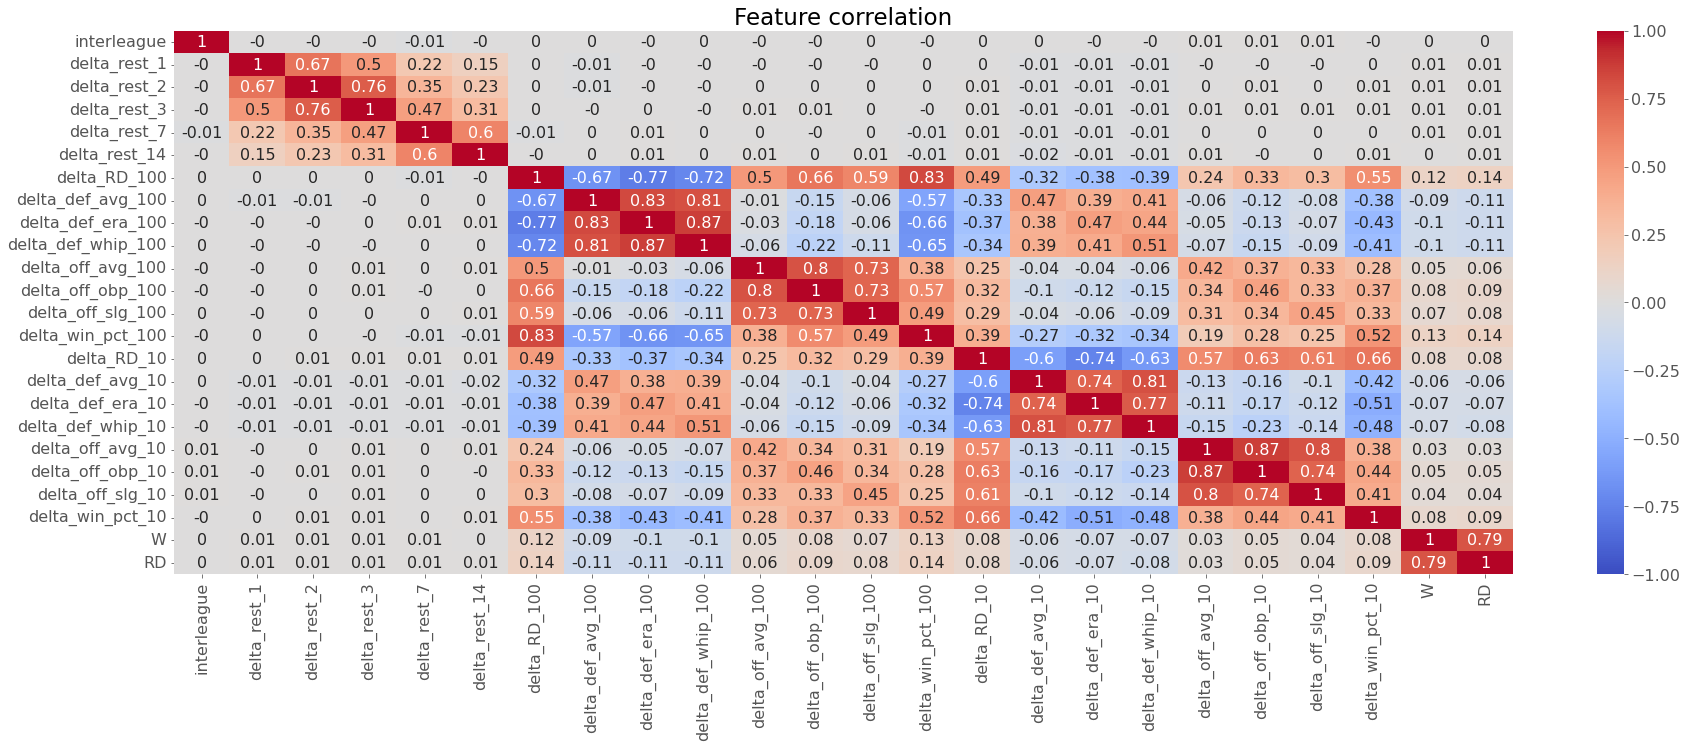

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(
    pd.concat(
        [
            X_context,
            X[['delta_rest_1', 'delta_rest_2', 'delta_rest_3', 'delta_rest_7', 'delta_rest_14']],
            X.drop(columns=[c for c in X.columns if not c.endswith('100')]),
            X.drop(columns=[c for c in X.columns if not c.endswith('10')] + ['delta_rest_10']),
            y
        ],
        axis=1).corr().round(2),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="coolwarm"
)
plt.title("Feature correlation")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(
    solver='saga',
    random_state=42
)

parameters = {
    'C': np.linspace(50, 1000, 10),
    'penalty': ['l1', 'l2']
}

cv = ShuffleSplit(
    n_splits=5,
    test_size=0.1,
    random_state=42
)

clf = GridSearchCV(
    logistic_clf,
    parameters,
    scoring=['accuracy', 'f1_macro', 'roc_auc', 'neg_log_loss'],
    refit='neg_log_loss',
    cv=cv,
)

clf.fit(
    X[['delta_rest_3', 'delta_def_whip_100', 'delta_off_avg_100', 'delta_RD_100', 'delta_win_pct_10', 'delta_def_whip_10']],
    y['W']
)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
             estimator=LogisticRegression(random_state=42, solver='saga'),
             param_grid={'C': array([  50.        ,  155.55555556,  261.11111111,  366.66666667,
        472.22222222,  577.77777778,  683.33333333,  788.88888889,
        894.44444444, 1000.        ]),
                         'penalty': ['l1', 'l2']},
             refit='neg_log_loss',
             scoring=['accuracy', 'f1_macro', 'roc_auc', 'neg_log_loss'])

In [ ]:
clf.cv_results_

In [ ]:
clf.best_params_

{'C': 1000.0, 'penalty': 'l2'}

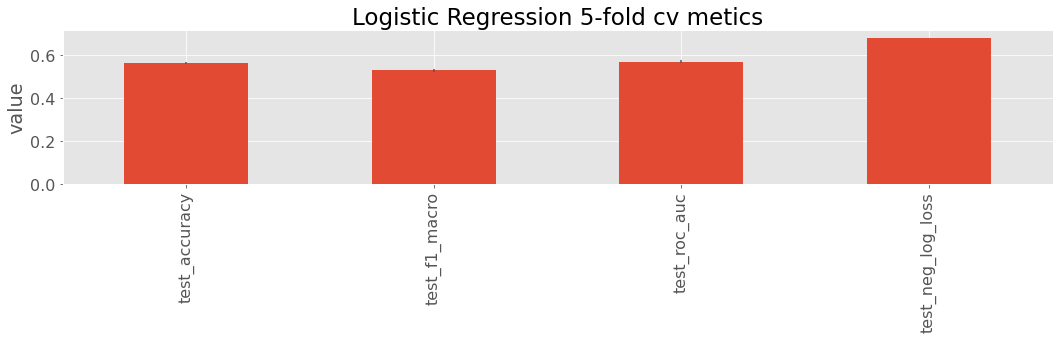

In [ ]:
from sklearn.model_selection import cross_validate

res = cross_validate(
    clf.best_estimator_,
    X[['delta_rest_3', 'delta_def_whip_100', 'delta_off_slg_100', 'delta_RD_100']],
    y['W'],
    cv=cv,
    scoring=['accuracy', 'f1_macro', 'roc_auc', 'neg_log_loss']
)

data = [abs(x.mean()) for name, x in res.items() if name.startswith('test')]
metrics = pd.Series(
    data=data,
    index=[name for name in res.keys() if name.startswith('test')]
)
std = [np.std(x) for name, x in res.items() if name.startswith('test')]
fig, ax = plt.subplots(figsize=(15,5))
metrics.plot.bar(yerr=std, ax=ax)
ax.set_title("Logistic Regression 5-fold cv metics")
ax.set_ylabel("value")
fig.tight_layout()

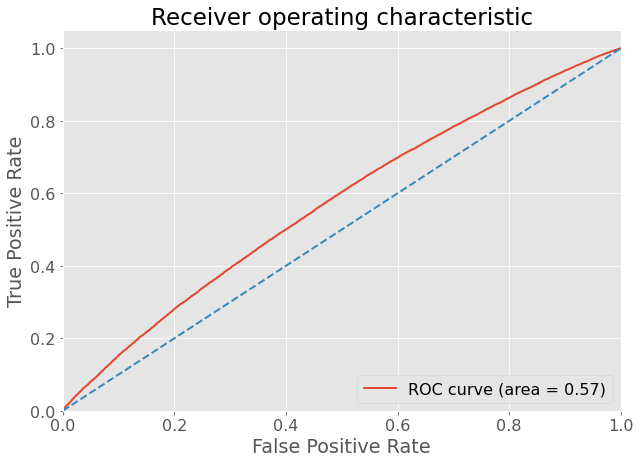

In [ ]:
#hide_input
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(
    y[['W']],
    clf.best_estimator_.predict_proba(X[['delta_rest_3', 'delta_def_whip_100', 'delta_off_avg_100', 'delta_RD_100', 'delta_win_pct_10', 'delta_def_whip_10']])[:,1],
    pos_label=1
)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,7))
lw = 2
plt.plot(
    fpr,
    tpr,
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# random forest

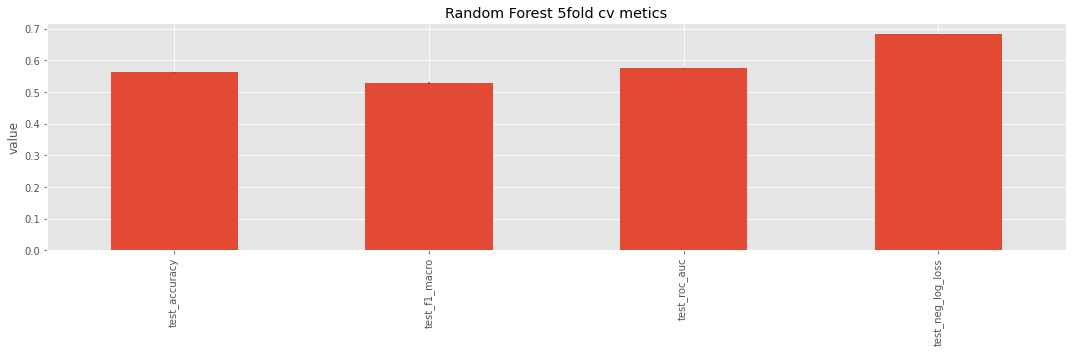

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(
    n_estimators=200,
    criterion='entropy',
    max_depth=3,
    random_state=0
)

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
res = cross_validate(
    clf,
    X_d_100,
    y,
    cv=cv,
    scoring=['accuracy', 'f1_macro', 'roc_auc', 'neg_log_loss']
)

data = [abs(x.mean()) for name, x in res.items() if name.startswith('test')]
metrics = pd.Series(
    data=data,
    index=[name for name in res.keys() if name.startswith('test')]
)
std = [np.std(x) for name, x in res.items() if name.startswith('test')]
fig, ax = plt.subplots(figsize=(15,5))
metrics.plot.bar(yerr=std, ax=ax)
ax.set_title("Random Forest 5-fold cv metics")
ax.set_ylabel("value")
fig.tight_layout()

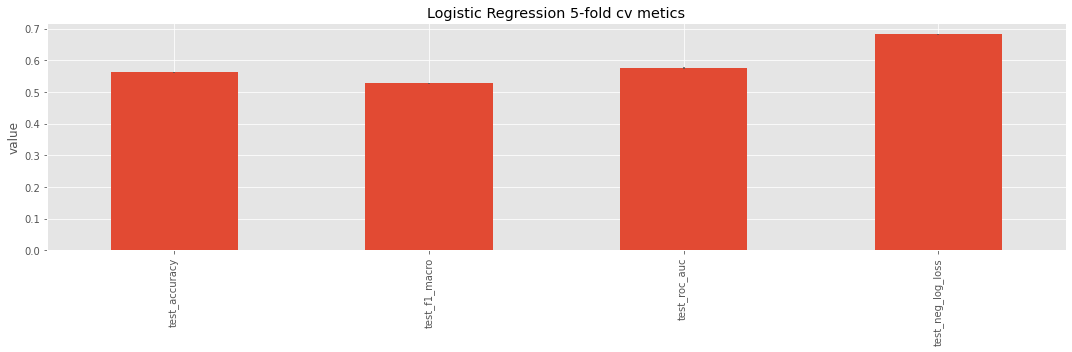

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(
    penalty='l2', # {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}
    random_state=42
)

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
res = cross_validate(
    logistic_clf,
    X_d_100,
    y,
    cv=cv,
    scoring=['accuracy', 'f1_macro', 'roc_auc', 'neg_log_loss']
)

data = [abs(x.mean()) for name, x in res.items() if name.startswith('test')]
metrics = pd.Series(
    data=data,
    index=[name for name in res.keys() if name.startswith('test')]
)
std = [np.std(x) for name, x in res.items() if name.startswith('test')]
fig, ax = plt.subplots(figsize=(15,5))
metrics.plot.bar(yerr=std, ax=ax)
ax.set_title("Logistic Regression 5-fold cv metics")
ax.set_ylabel("value")
fig.tight_layout()

In [ ]:
from sklearn.model_selection import train_test_split

X_d_100 = X_d[[c for c in X_d.columns if c.endswith('100')]]

X_train, X_test, y_train, y_test = train_test_split(X_d_100, y, stratify=y, train_size=.9, random_state=42)

clf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       random_state=0)

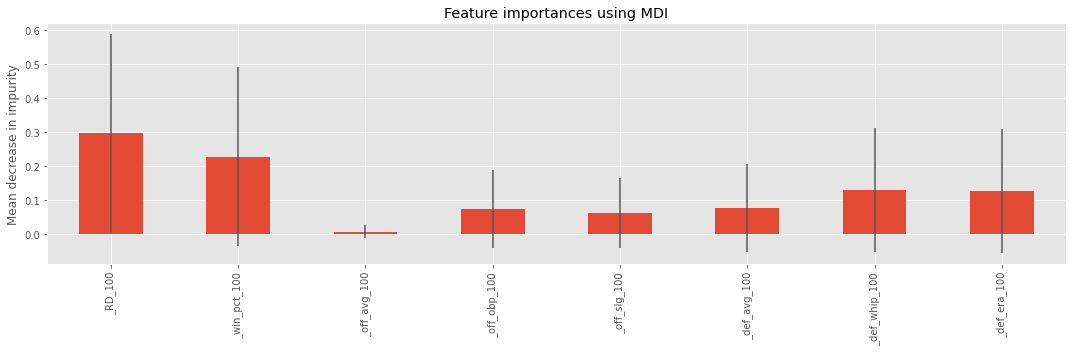

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_d_100.columns)

fig, ax = plt.subplots(figsize=(15,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

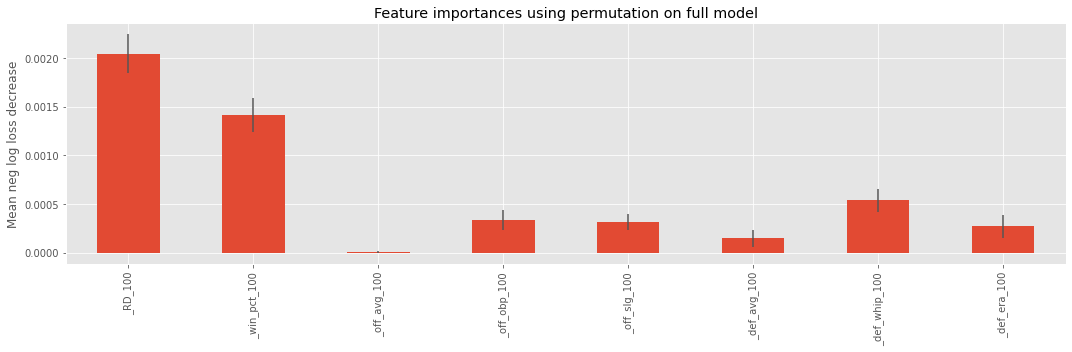

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    clf, X_test, y_test, scoring='neg_log_loss', n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_d_100.columns)

fig, ax = plt.subplots(figsize=(15,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean neg log loss decrease")
fig.tight_layout()
plt.show()

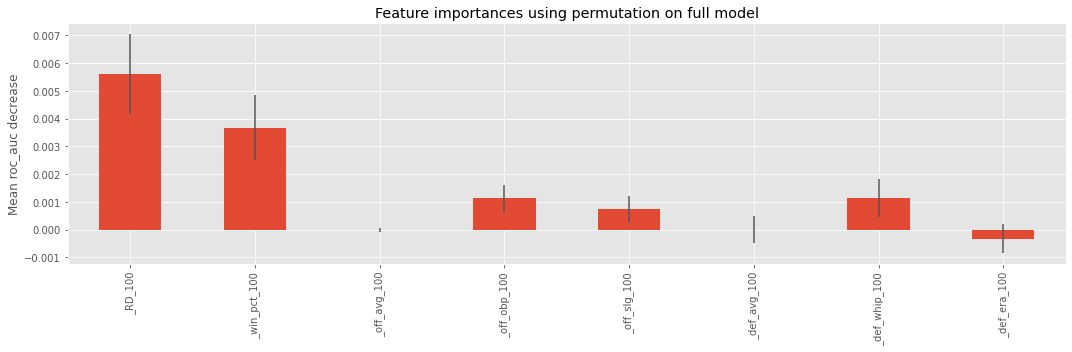

In [ ]:
result = permutation_importance(
    clf, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_d_100.columns)

fig, ax = plt.subplots(figsize=(15,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean roc_auc decrease")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

base_clf = RandomForestClassifier(
    random_state=42
)

clf = CalibratedClassifierCV(
    base_estimator=base_clf
)

cv = ShuffleSplit(
    n_splits=5,
    test_size=0.3,
    random_state=42
)

# n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
# min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False,

distributions = {
    'n_estimators': list(range(10, 200)),
    'max_depth': list(range(2, 10)),
    'min_samples_split': list(range(2, 25)),
    'criterion': ['gini', 'entropy']
}

search = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=distributions,
    cv=cv,
    n_iter=5,
    scoring=['accuracy', 'f1_macro', 'roc_auc', 'neg_log_loss'],
    refit='neg_log_loss',
    verbose=3,
    error_score="raise",
    random_state=42
)

result = search.fit(X_d, y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END criterion=gini, max_depth=5, min_samples_split=16, n_estimators=35; accuracy: (test=0.561) f1_macro: (test=0.527) neg_log_loss: (test=-0.682) roc_auc: (test=0.573) total time=   6.0s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_split=16, n_estimators=35; accuracy: (test=0.561) f1_macro: (test=0.528) neg_log_loss: (test=-0.682) roc_auc: (test=0.571) total time=   5.0s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_split=16, n_estimators=35; accuracy: (test=0.563) f1_macro: (test=0.534) neg_log_loss: (test=-0.682) roc_auc: (test=0.569) total time=   5.0s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_split=16, n_estimators=35; accuracy: (test=0.561) f1_macro: (test=0.529) neg_log_loss: (test=-0.682) roc_auc: (test=0.572) total time=   5.0s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_split=16, n_estimators=35; accuracy: (test=0.563) f1_macro: (test=0.533) neg_log_loss: (test=-0.682) r